# **TEXT MINING PROJECT**: 20 NEWS GROUP CLASSIFICATION  

Antonella Zaccaria  
Marco Savino

Librerie utilizzate

In [1]:
from sklearn.datasets import fetch_20newsgroups

import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt') #serve per la tokenizzazione

nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from nltk.stem import PorterStemmer

from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Carichiamo il dataset 20 News Group direttamente dal **sklearn** e lo salviamo in formato csv

In [0]:
def twenty_newsgroup_to_csv():
    newsgroups = fetch_20newsgroups(subset = 'all', shuffle=True)

    df = pd.DataFrame([newsgroups.data, newsgroups.target.tolist()]).T
    df.columns = ['text', 'target']
  
twenty_newsgroup_to_csv()

In [0]:
df = pd.read_csv('20_news.csv')

Visualizziamo le prime righe del dataset

In [4]:
df.head()

,Unnamed: 0,text,target,title
0,0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey
1,7,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
2,8,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
3,24,From: cs902043@ariel.yorku.ca (SHAWN LUDDINGTO...,10,rec.sport.hockey
4,44,From: gritter@cs.purdue.edu (Carl Gritter)\nSu...,10,rec.sport.hockey


Eliminiamo la colonna **Unnamed: 0**

In [0]:
df = df.drop('Unnamed: 0', 1)

In [6]:
df.head()

,text,target,title
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey
1,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
2,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey
3,From: cs902043@ariel.yorku.ca (SHAWN LUDDINGTO...,10,rec.sport.hockey
4,From: gritter@cs.purdue.edu (Carl Gritter)\nSu...,10,rec.sport.hockey


### **Data esploration**

Dimensione del dataset

In [7]:
df.shape

(18846, 3)

Controlliamo se sono presenti **na**

In [8]:
df.isnull().sum()

text      0
target    0
title     0
dtype: int64

Lista target

In [9]:
print(df.title.unique())

['rec.sport.hockey' 'comp.sys.ibm.pc.hardware' 'talk.politics.mideast'
 'comp.sys.mac.hardware' 'sci.electronics' 'talk.religion.misc'
 'sci.crypt' 'sci.med' 'alt.atheism' 'rec.motorcycles' 'rec.autos'
 'comp.windows.x' 'comp.graphics' 'sci.space' 'talk.politics.guns'
 'misc.forsale' 'rec.sport.baseball' 'talk.politics.misc'
 'comp.os.ms-windows.misc' 'soc.religion.christian']


In [10]:
print(df.target.unique())

[10  3 17  4 12 19 11 13  0  8  7  5  1 14 16  6  9 18  2 15]


Controlliamo se le categorie (target) sono bilanciate

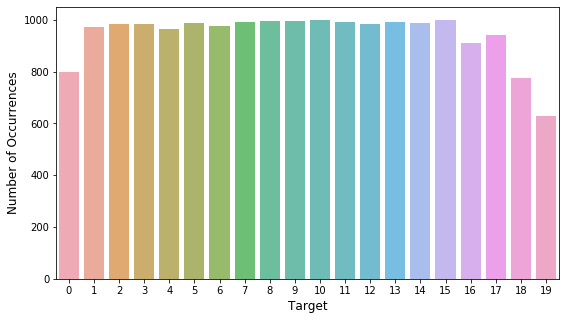

In [11]:
count_target = df['target'].value_counts()

plt.figure(figsize=(9,5))
sns.barplot(count_target.index, count_target.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target', fontsize=12);

### **Preprocessing**

Per le operazioni di preprocessing creiamo una nuova colonna del DataFrame df chiamata **text_processed**, mantenendo la colonna del testo originale

**1.** Conversione del testo in minuscolo

In [0]:
df['text_processed'] = df['text'].map(lambda x: x.lower())

**2.** Eliminazione indirizzi mail

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('\S*@\S*\s?',' ', x))

**3.** Eliminazione numeri

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('\d+',' ', x))

**4.** Eliminazione caratteri di punteggiatura

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: re.sub(r'[^\w]', ' ', x))

**5.** Rimozione parole composta da 1 e due lettere

In [0]:
df['text_processed'] = df['text_processed'].astype(str).map(lambda x: re.sub(r'\b\w{1,2}\b', '', x))

**6.** Sistemazione degli spazi che si sono creati con le precedenti operazioni

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: x.lstrip()) #rimozione spazi di inizio riga

In [0]:
df['text_processed'] = df['text_processed'].map(lambda x: x.rstrip()) #rimozione spazi di fine riga

**7.** Tokenizzazione

In [0]:
df['text_processed'] = df['text_processed'].apply(lambda x: nltk.word_tokenize(x))

**8.** Rimozione Stopwords

In [0]:
#lista stop_words
en_stopwords = stopwords.words ('english')

In [22]:
#numero di stopwords
len(en_stopwords)

179

In [0]:
df['text_processed'] = df['text_processed'].apply(lambda x: [item for item in x if item not in en_stopwords])

Per effettuare le operazioni di lemmatizzazione e stemming verranno create due nuove colonne (rispettivamente **text_processed_lem** e **text_processed_stem**) in modo da separare le due operazioni

**9.** Lemmatizzazione  

In [0]:
lemmatizer = WordNetLemmatizer()

In [0]:
df['text_processed_lem'] = df['text_processed'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

**10.** Stemming

In [0]:
ps = PorterStemmer()

In [0]:
df['text_processed_stem'] = df['text_processed'].apply(lambda x: [ps.stem(y) for y in x])

Teminata la fase di preprocessing del testo suddividiamo il Dataset in **train set (60%)** e **test set (40%)** in modo da poter addestrare e testare il classificatore  

**train_lem_x**: train set  di text_processed_lem  
**train_lem_y**: target train di set text_processed_lem  
**test_lem_x**: test set di text_processed_lem   
**test_lem_y**: target test di text_processed_lem 

**train_stem_x**: train set  di text_processed_stem  
**train_stem_y**: target train di set text_processed_stem  
**test_stem_x**: test set di text_processed_stem   
**test_stem_y**: target test di text_processed_stem 



In [0]:
train_lem_x, test_lem_x, train_lem_y, test_lem_y = model_selection.train_test_split(df['text_processed_lem'], df['target'], 
                                                                                    train_size= 0.6, test_size= 0.4, 
                                                                                    random_state = 123, shuffle = True)

In [0]:
train_stem_x, test_stem_x, train_stem_y, test_stem_y = model_selection.train_test_split(df['text_processed_stem'], df['target'], 
                                                                                    train_size= 0.6, test_size= 0.4, 
                                                                                    random_state = 123, shuffle = True)

In [30]:
print('La dimensione del train set dei dati "lemmatizzati" (train_lem_x) è', len(train_lem_x))
print('La dimensione del test set dei dati "lemmatizzati" (test_lem_x) è', len(test_lem_x))

print('La dimensione del train set dei dati "stemmatizzati" (train_stem_x) è', len(train_stem_x))
print('La dimensione del test set dei dati "stemmatizzati" (test_stem_x) è', len(test_stem_x))


La dimensione del train set dei dati "lemmatizzati" (train_lem_x) è 11307
La dimensione del test set dei dati "lemmatizzati" (test_lem_x) è 7539
La dimensione del train set dei dati "stemmatizzati" (train_stem_x) è 11307
La dimensione del test set dei dati "stemmatizzati" (test_stem_x) è 7539


In [87]:
train_stem_y

7995      0
14087    16
8058      0
4607     12
16909     2
         ..
13435    16
7763      0
15377     9
17730     2
15725     9
Name: target, Length: 11307, dtype: int64

### **Feature Engineering**  
In questa fase creiamo le strutture **tf** e **tf-idf** che saranno poi utilizzate dagli algoritmi di Machine Learning per effettuare la classificazione

**Term Frequency**

In [0]:
count_vect = CountVectorizer(analyzer='word')

I quattro passaggi successivi servono per adeguare il formato alla funzione di creazione della matrice tf

In [0]:
a = train_lem_x.astype(str)

In [0]:
b = test_lem_x.astype(str)

In [0]:
c = train_stem_x.astype(str)

In [0]:
d = test_stem_x.astype(str)

Creazione matrice tf per train_lem_x

In [36]:
tf_train_lem_x = count_vect.fit_transform(a)
tf_train_lem_x

<11307x73262 sparse matrix of type '<class 'numpy.int64'>'
	with 1128756 stored elements in Compressed Sparse Row format>

Creazione matrice tf per test_lem_x

In [37]:
tf_test_lem_x = count_vect.transform(b)
tf_test_lem_x

<7539x73262 sparse matrix of type '<class 'numpy.int64'>'
	with 729374 stored elements in Compressed Sparse Row format>

Creazione matrice tf per train_stem_x

In [38]:
tf_train_stem_x = count_vect.fit_transform(c)
tf_train_stem_x

<11307x60398 sparse matrix of type '<class 'numpy.int64'>'
	with 1091121 stored elements in Compressed Sparse Row format>

Creazione matrice tf per test_stem_x

In [39]:
tf_test_stem_x = count_vect.fit_transform(d)
tf_test_stem_x

<7539x51706 sparse matrix of type '<class 'numpy.int64'>'
	with 730737 stored elements in Compressed Sparse Row format>

**TF-IDF unigram** 

In [0]:
tfidf = TfidfVectorizer(max_features=20000, analyzer='word',ngram_range=(1,1))

Creazione matrice tf-idf per train_lem_x

In [0]:
tfidf.fit(a)
tfidf_train_lem_x =  tfidf.transform(a)

In [95]:
tfidf_train_lem_x

<11307x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1046216 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per test_lem_x

In [0]:
#tfidf.fit(b)
tfidf_test_lem_x =  tfidf.transform(b)

In [97]:
tfidf_test_lem_x

<7539x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 698889 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per train_stem_x

In [0]:
tfidf.fit(c)
tfidf_train_stem_x =  tfidf.transform(c)

In [106]:
tfidf_train_stem_x

<11307x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1036595 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf per test_stem_x

In [0]:
#tfidf.fit(d)
tfidf_test_stem_x =  tfidf.transform(d)

In [0]:
tfidf_test_stem_x

**TF-IDF unigram + bigram** 

In [0]:
bi_tfidf = TfidfVectorizer(max_features=20000, analyzer='word',ngram_range=(1,2))

Creazione matrice tf-idf bigram per train_lem_x

In [0]:
bi_tfidf.fit(a)
bi_train_lem_x =  bi_tfidf.transform(a)

In [113]:
bi_train_lem_x

<11307x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1212679 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per test_lem_x

In [0]:
#bi_tfidf.fit(b)
bi_test_lem_x =  bi_tfidf.transform(b)

In [0]:
bi_test_lem_x

Creazione matrice tf-idf bigram per train_stem_x

In [0]:
bi_tfidf.fit(c)
bi_train_stem_x =  bi_tfidf.transform(c)

In [118]:
bi_train_stem_x

<11307x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1233687 stored elements in Compressed Sparse Row format>

Creazione matrice tf-idf bigram per test_stem_x

In [0]:
#bi_tfidf.fit(d)
bi_test_stem_x =  bi_tfidf.transform(d)

In [120]:
bi_test_stem_x

<7539x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 809503 stored elements in Compressed Sparse Row format>

### **Classification**

**1. Naive Bayes**

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [0]:
clf = MultinomialNB()

1.1 Naive Bayes con TF + Lemmatization

In [83]:
clf.fit(tf_train_lem_x, train_lem_y)
predicted = clf.predict(tf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       340
           1       0.70      0.88      0.78       374
           2       0.94      0.64      0.76       400
           3       0.74      0.80      0.77       393
           4       0.80      0.90      0.85       358
           5       0.81      0.88      0.84       416
           6       0.90      0.74      0.82       386
           7       0.89      0.92      0.90       396
           8       0.96      0.93      0.95       393
           9       0.97      0.94      0.96       405
          10       0.95      0.97      0.96       386
          11       0.90      0.96      0.93       400
          12       0.89      0.79      0.84       406
          13       0.95      0.95      0.95       380
          14       0.96      0.94      0.95       403
          15       0.86      0.94      0.89       391
          16       0.82      0.93      0.87       380
          17       0.96    

In [57]:
accuracy_score(test_lem_y, predicted)

0.8719989388513065

**aggiungere confusion matrix**

1.2 Naive Bayes con TF + Stemming **da sistemare**

In [0]:
count_vect = CountVectorizer()

In [0]:
c = train_stem_x
d = test_stem_x

In [0]:
tf_train_stem_x = count_vect.fit_transform(c.astype(str))
#tf_train_stem_x

tf_test_stem_x = count_vect.fit_transform(d.astype(str))
#tf_test_stem_x

In [82]:
clf.fit(tf_train_stem_x, train_stem_y)
predicted = clf.predict(tf_test_stem_x)
print(metrics.classification_report(test_stem_y, predicted))

ValueError: ignored

1.3 Naive Bayes con TF-IDF + Lemmatization

In [101]:
clf.fit(tfidf_train_lem_x, train_lem_y)
predicted = clf.predict(tfidf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80       340
           1       0.76      0.86      0.81       374
           2       0.84      0.82      0.83       400
           3       0.75      0.80      0.77       393
           4       0.80      0.91      0.85       358
           5       0.92      0.86      0.89       416
           6       0.88      0.80      0.84       386
           7       0.90      0.92      0.91       396
           8       0.94      0.96      0.95       393
           9       0.96      0.95      0.96       405
          10       0.95      0.98      0.96       386
          11       0.88      0.97      0.92       400
          12       0.90      0.77      0.83       406
          13       0.94      0.93      0.93       380
          14       0.95      0.93      0.94       403
          15       0.67      0.96      0.79       391
          16       0.79      0.96      0.86       380
          17       0.95    

1.4 Naive Bayes con TF-IDF + Stemming

In [108]:
clf.fit(tfidf_train_stem_x, train_stem_y)
predicted = clf.predict(tfidf_test_stem_x)
print(classification_report(test_stem_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.73      0.79       340
           1       0.76      0.86      0.81       374
           2       0.84      0.81      0.83       400
           3       0.75      0.80      0.77       393
           4       0.80      0.90      0.85       358
           5       0.93      0.85      0.89       416
           6       0.88      0.78      0.83       386
           7       0.90      0.92      0.91       396
           8       0.95      0.96      0.96       393
           9       0.96      0.94      0.95       405
          10       0.95      0.98      0.97       386
          11       0.84      0.97      0.90       400
          12       0.89      0.75      0.81       406
          13       0.94      0.93      0.94       380
          14       0.94      0.93      0.94       403
          15       0.66      0.96      0.78       391
          16       0.77      0.96      0.86       380
          17       0.95    

1.5 Naive Bayes con Bigram + Lemmatization

In [115]:
clf.fit(bi_train_lem_x, train_lem_y)
predicted = clf.predict(bi_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       340
           1       0.74      0.87      0.80       374
           2       0.84      0.81      0.83       400
           3       0.76      0.79      0.77       393
           4       0.78      0.89      0.83       358
           5       0.91      0.87      0.89       416
           6       0.84      0.84      0.84       386
           7       0.90      0.90      0.90       396
           8       0.95      0.95      0.95       393
           9       0.96      0.93      0.95       405
          10       0.93      0.98      0.95       386
          11       0.94      0.95      0.95       400
          12       0.89      0.77      0.83       406
          13       0.93      0.93      0.93       380
          14       0.95      0.92      0.93       403
          15       0.71      0.95      0.81       391
          16       0.81      0.95      0.88       380
          17       0.95    

1.6 Naive Bayes con Bigram + Stemming

In [121]:
clf.fit(bi_train_stem_x, train_stem_y)
predicted = clf.predict(bi_test_stem_x)
print(classification_report(test_stem_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       340
           1       0.74      0.85      0.79       374
           2       0.84      0.81      0.83       400
           3       0.75      0.78      0.77       393
           4       0.80      0.89      0.84       358
           5       0.90      0.88      0.89       416
           6       0.84      0.83      0.83       386
           7       0.90      0.91      0.90       396
           8       0.95      0.95      0.95       393
           9       0.95      0.94      0.95       405
          10       0.94      0.97      0.96       386
          11       0.93      0.96      0.94       400
          12       0.89      0.78      0.83       406
          13       0.92      0.93      0.92       380
          14       0.95      0.93      0.94       403
          15       0.71      0.96      0.82       391
          16       0.81      0.95      0.87       380
          17       0.95    

**2. Support Vector Machine (SVM)**

In [0]:
from sklearn import svm

In [0]:
clf = svm.SVC()

2.1 SVM con TF + Lemmatization

In [124]:
clf.fit(tf_train_lem_x, train_lem_y)
predicted = clf.predict(tf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.85      0.69      0.76       340
           1       0.43      0.85      0.57       374
           2       0.81      0.64      0.71       400
           3       0.77      0.65      0.70       393
           4       0.84      0.81      0.82       358
           5       0.87      0.72      0.79       416
           6       0.63      0.87      0.73       386
           7       0.88      0.82      0.85       396
           8       0.93      0.87      0.90       393
           9       0.88      0.89      0.89       405
          10       0.98      0.84      0.91       386
          11       0.98      0.84      0.90       400
          12       0.60      0.80      0.68       406
          13       0.82      0.81      0.81       380
          14       0.96      0.78      0.86       403
          15       0.81      0.87      0.84       391
          16       0.86      0.78      0.81       380
          17       0.71    

2.2 SVM con TF + Stemming

In [125]:
clf.fit(tf_train_stem_x, train_stem_y)
predicted = clf.predict(tf_test_stem_x)
print(metrics.classification_report(test_stem_y, predicted))

ValueError: ignored

2.3 SVM con TF-IDF + Lemmatization

In [126]:
clf.fit(tfidf_train_lem_x, train_lem_y)
predicted = clf.predict(tfidf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       340
           1       0.75      0.91      0.82       374
           2       0.85      0.83      0.84       400
           3       0.79      0.81      0.80       393
           4       0.92      0.87      0.89       358
           5       0.90      0.89      0.89       416
           6       0.85      0.87      0.86       386
           7       0.93      0.92      0.92       396
           8       0.98      0.95      0.96       393
           9       0.96      0.97      0.96       405
          10       0.98      0.96      0.97       386
          11       0.99      0.92      0.95       400
          12       0.82      0.89      0.86       406
          13       0.91      0.95      0.93       380
          14       0.98      0.93      0.95       403
          15       0.87      0.94      0.90       391
          16       0.90      0.92      0.91       380
          17       0.99    

2.4 SVM con TF-IDF + Stemming

In [132]:
clf.fit(tfidf_train_stem_x, train_stem_y)
predicted = clf.predict(tfidf_test_stem_x)
print(classification_report(test_stem_y, predicted))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       340
           1       0.73      0.91      0.81       374
           2       0.86      0.83      0.84       400
           3       0.80      0.81      0.81       393
           4       0.91      0.87      0.89       358
           5       0.89      0.89      0.89       416
           6       0.85      0.87      0.86       386
           7       0.93      0.92      0.92       396
           8       0.98      0.96      0.97       393
           9       0.98      0.97      0.97       405
          10       0.99      0.97      0.98       386
          11       0.99      0.92      0.95       400
          12       0.82      0.90      0.86       406
          13       0.91      0.95      0.93       380
          14       0.98      0.93      0.96       403
          15       0.88      0.94      0.91       391
          16       0.90      0.91      0.91       380
          17       0.99    

2.5 SVM con Bigram + Lemmatization

In [143]:
clf.fit(bi_train_lem_x, train_lem_y)
predicted = clf.predict(bi_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       340
           1       0.71      0.90      0.80       374
           2       0.86      0.82      0.84       400
           3       0.79      0.80      0.79       393
           4       0.89      0.88      0.89       358
           5       0.91      0.88      0.90       416
           6       0.85      0.88      0.87       386
           7       0.92      0.89      0.91       396
           8       0.97      0.95      0.96       393
           9       0.97      0.96      0.96       405
          10       0.99      0.96      0.97       386
          11       0.99      0.92      0.96       400
          12       0.81      0.89      0.85       406
          13       0.90      0.95      0.92       380
          14       0.98      0.93      0.95       403
          15       0.89      0.94      0.91       391
          16       0.91      0.92      0.91       380
          17       0.99    

2.6 SVM con Bigram + Stemming

In [144]:
clf.fit(bi_train_stem_x, train_stem_y)
predicted = clf.predict(bi_test_stem_x)
print(classification_report(test_stem_y, predicted))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       340
           1       0.71      0.90      0.79       374
           2       0.86      0.82      0.84       400
           3       0.79      0.79      0.79       393
           4       0.90      0.88      0.89       358
           5       0.90      0.88      0.89       416
           6       0.84      0.88      0.86       386
           7       0.92      0.91      0.91       396
           8       0.99      0.96      0.97       393
           9       0.97      0.96      0.97       405
          10       0.99      0.96      0.97       386
          11       0.99      0.93      0.96       400
          12       0.82      0.89      0.85       406
          13       0.91      0.94      0.93       380
          14       0.98      0.93      0.95       403
          15       0.89      0.94      0.91       391
          16       0.91      0.92      0.91       380
          17       0.99    

**3. Random Forest**

3.1 Random Forest con TF + Lemmatization

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
clf = RandomForestClassifier()

In [147]:
clf.fit(tf_train_lem_x, train_lem_y)
predicted = clf.predict(tf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       340
           1       0.67      0.78      0.72       374
           2       0.72      0.82      0.77       400
           3       0.74      0.72      0.73       393
           4       0.80      0.81      0.81       358
           5       0.84      0.81      0.82       416
           6       0.77      0.90      0.83       386
           7       0.86      0.87      0.86       396
           8       0.95      0.92      0.93       393
           9       0.89      0.93      0.91       405
          10       0.92      0.96      0.94       386
          11       0.95      0.94      0.95       400
          12       0.87      0.67      0.75       406
          13       0.90      0.87      0.88       380
          14       0.87      0.90      0.89       403
          15       0.76      0.94      0.84       391
          16       0.80      0.92      0.86       380
          17       0.96    

3.2 Random Forest con TF + Stemming

In [148]:
clf.fit(tf_train_stem_x, train_stem_y)
predicted = clf.predict(tf_test_stem_x)
print(metrics.classification_report(test_stem_y, predicted))

ValueError: ignored

3.3 Random Forest con TF-IDF + Lemmatization

In [149]:
clf.fit(tfidf_train_lem_x, train_lem_y)
predicted = clf.predict(tfidf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.85      0.70      0.77       340
           1       0.66      0.79      0.72       374
           2       0.73      0.82      0.78       400
           3       0.75      0.69      0.72       393
           4       0.79      0.84      0.82       358
           5       0.87      0.78      0.82       416
           6       0.79      0.88      0.83       386
           7       0.85      0.85      0.85       396
           8       0.92      0.89      0.91       393
           9       0.88      0.92      0.90       405
          10       0.91      0.93      0.92       386
          11       0.92      0.92      0.92       400
          12       0.83      0.66      0.73       406
          13       0.83      0.89      0.86       380
          14       0.84      0.89      0.86       403
          15       0.74      0.91      0.81       391
          16       0.78      0.89      0.83       380
          17       0.95    

3.4 Random Forest con TF-IDF + Stemming

In [150]:
clf.fit(tfidf_train_stem_x, train_stem_y)
predicted = clf.predict(tfidf_test_stem_x)
print(classification_report(test_stem_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.73      0.79       340
           1       0.65      0.76      0.70       374
           2       0.77      0.82      0.79       400
           3       0.73      0.70      0.72       393
           4       0.81      0.80      0.81       358
           5       0.82      0.79      0.80       416
           6       0.79      0.85      0.82       386
           7       0.85      0.84      0.85       396
           8       0.91      0.90      0.91       393
           9       0.89      0.93      0.91       405
          10       0.92      0.95      0.94       386
          11       0.93      0.91      0.92       400
          12       0.79      0.69      0.74       406
          13       0.85      0.88      0.87       380
          14       0.84      0.90      0.87       403
          15       0.74      0.93      0.82       391
          16       0.79      0.90      0.84       380
          17       0.96    

3.5 Random Forest con Bigram + Lemmatization



In [151]:
clf.fit(bi_train_lem_x, train_lem_y)
predicted = clf.predict(bi_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.87      0.73      0.79       340
           1       0.64      0.77      0.70       374
           2       0.72      0.84      0.78       400
           3       0.73      0.69      0.71       393
           4       0.80      0.81      0.80       358
           5       0.88      0.77      0.82       416
           6       0.80      0.88      0.84       386
           7       0.84      0.84      0.84       396
           8       0.93      0.89      0.91       393
           9       0.88      0.90      0.89       405
          10       0.90      0.94      0.92       386
          11       0.95      0.92      0.93       400
          12       0.77      0.67      0.72       406
          13       0.84      0.87      0.86       380
          14       0.86      0.89      0.87       403
          15       0.77      0.94      0.84       391
          16       0.81      0.88      0.85       380
          17       0.96    

3.6 Random Forest con Bigram + Stemming

In [152]:
clf.fit(bi_train_stem_x, train_stem_y)
predicted = clf.predict(bi_test_stem_x)
print(classification_report(test_stem_y, predicted))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80       340
           1       0.60      0.76      0.67       374
           2       0.73      0.83      0.78       400
           3       0.75      0.68      0.71       393
           4       0.81      0.83      0.82       358
           5       0.87      0.77      0.82       416
           6       0.79      0.84      0.82       386
           7       0.85      0.83      0.84       396
           8       0.91      0.90      0.90       393
           9       0.87      0.90      0.89       405
          10       0.91      0.94      0.92       386
          11       0.95      0.93      0.94       400
          12       0.78      0.69      0.73       406
          13       0.84      0.87      0.85       380
          14       0.88      0.89      0.88       403
          15       0.76      0.93      0.83       391
          16       0.80      0.88      0.84       380
          17       0.95    

**4. Xtereme Gradient Boosting (xgboost)**

In [0]:
import xgboost as xgb

In [0]:
clf= xgb.XGBClassifier()

4.1 XGBOOST con TF + Lemmatization

In [155]:
clf.fit(tf_train_lem_x, train_lem_y)
predicted = clf.predict(tf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       340
           1       0.67      0.74      0.70       374
           2       0.70      0.78      0.74       400
           3       0.63      0.69      0.66       393
           4       0.80      0.79      0.79       358
           5       0.82      0.71      0.76       416
           6       0.80      0.83      0.82       386
           7       0.85      0.78      0.81       396
           8       0.92      0.87      0.89       393
           9       0.87      0.87      0.87       405
          10       0.94      0.86      0.90       386
          11       0.94      0.89      0.92       400
          12       0.57      0.70      0.63       406
          13       0.88      0.84      0.86       380
          14       0.85      0.86      0.86       403
          15       0.74      0.90      0.81       391
          16       0.78      0.83      0.81       380
          17       0.96    

4.2 XGBOOST con TF + Stemming

In [156]:
clf.fit(tf_train_stem_x, train_stem_y)
predicted = clf.predict(tf_test_stem_x)
print(metrics.classification_report(test_stem_y, predicted))

ValueError: ignored

4.3 XGBOOST con TF-IDF + Lemmatization

In [157]:
clf.fit(tfidf_train_lem_x, train_lem_y)
predicted = clf.predict(tfidf_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       340
           1       0.67      0.74      0.70       374
           2       0.70      0.77      0.74       400
           3       0.63      0.71      0.67       393
           4       0.80      0.78      0.79       358
           5       0.80      0.72      0.76       416
           6       0.81      0.83      0.82       386
           7       0.85      0.80      0.82       396
           8       0.92      0.86      0.89       393
           9       0.86      0.86      0.86       405
          10       0.94      0.85      0.89       386
          11       0.94      0.89      0.91       400
          12       0.58      0.70      0.64       406
          13       0.86      0.84      0.85       380
          14       0.84      0.86      0.85       403
          15       0.73      0.90      0.81       391
          16       0.80      0.81      0.80       380
          17       0.95    

4.4 XGBOOST con TF-IDF + Stemming

In [158]:
clf.fit(tfidf_train_stem_x, train_stem_y)
predicted = clf.predict(tfidf_test_stem_x)
print(classification_report(test_stem_y, predicted))

              precision    recall  f1-score   support

           0       0.82      0.70      0.75       340
           1       0.66      0.74      0.70       374
           2       0.70      0.76      0.73       400
           3       0.61      0.70      0.65       393
           4       0.80      0.77      0.78       358
           5       0.80      0.72      0.76       416
           6       0.79      0.81      0.80       386
           7       0.83      0.79      0.81       396
           8       0.92      0.86      0.89       393
           9       0.89      0.86      0.87       405
          10       0.93      0.88      0.90       386
          11       0.96      0.89      0.92       400
          12       0.58      0.70      0.64       406
          13       0.86      0.83      0.85       380
          14       0.85      0.85      0.85       403
          15       0.74      0.89      0.81       391
          16       0.77      0.80      0.79       380
          17       0.96    

4.5 XGBOOST con Bigram + Lemmatization

In [159]:
clf.fit(bi_train_lem_x, train_lem_y)
predicted = clf.predict(bi_test_lem_x)
print(classification_report(test_lem_y, predicted))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77       340
           1       0.69      0.73      0.71       374
           2       0.71      0.78      0.74       400
           3       0.64      0.71      0.67       393
           4       0.80      0.78      0.79       358
           5       0.84      0.76      0.80       416
           6       0.81      0.82      0.81       386
           7       0.84      0.80      0.82       396
           8       0.93      0.87      0.89       393
           9       0.88      0.87      0.88       405
          10       0.95      0.87      0.91       386
          11       0.94      0.89      0.91       400
          12       0.58      0.72      0.64       406
          13       0.87      0.84      0.85       380
          14       0.84      0.85      0.85       403
          15       0.75      0.91      0.82       391
          16       0.79      0.80      0.80       380
          17       0.95    

4.6 XGBOOST con Bigram + Stemming

In [160]:
clf.fit(bi_train_stem_x, train_stem_y)
predicted = clf.predict(bi_test_stem_x)
print(classification_report(test_stem_y, predicted))

              precision    recall  f1-score   support

           0       0.84      0.72      0.77       340
           1       0.66      0.74      0.70       374
           2       0.69      0.79      0.74       400
           3       0.63      0.69      0.66       393
           4       0.80      0.77      0.79       358
           5       0.85      0.76      0.80       416
           6       0.79      0.82      0.81       386
           7       0.84      0.79      0.81       396
           8       0.91      0.87      0.89       393
           9       0.89      0.87      0.88       405
          10       0.92      0.88      0.90       386
          11       0.96      0.89      0.92       400
          12       0.60      0.70      0.65       406
          13       0.86      0.84      0.85       380
          14       0.85      0.86      0.86       403
          15       0.76      0.91      0.83       391
          16       0.78      0.80      0.79       380
          17       0.96    